In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import scipy
import scipy.signal as signal
import scipy.interpolate as interpolate
import fitsio

In [2]:
class MapImage(object):
    def __init__(self, dimage=0.75, rough_length=12.):
        self.dimage = dimage
        self.rough_length = rough_length
        self.nside = (np.int32(np.ceil(self.rough_length / self.dimage)) // 2) * 2 + 1
        self.length = self.nside * self.dimage
        self.ximage = (self.length * np.outer(np.ones(self.nside),
                                              (np.arange(self.nside) + 0.5) /
                                              np.float64(self.nside) - 0.5)).flatten()
        self.yimage = (self.length * np.outer((np.arange(self.nside) + 0.5) /
                                              np.float64(self.nside) - 0.5,
                                              np.ones(self.nside))).flatten()
        self.xmin = - 0.5 * self.length
        self.xmax = 0.5 * self.length
        self.ymin = - 0.5 * self.length
        self.ymax = 0.5 * self.length
        self.xlin = self.ximage.reshape(self.nside, self.nside)[0, :]
        self.ylin = self.yimage.reshape(self.nside, self.nside)[:, 0]
        self.nimage = self.nside * self.nside
        return

    def set_kernel(self, sigma=0.64):
        n = 1001
        y = self.length * (np.outer(np.arange(n), np.ones(n)) - np.float64(n // 2)) / np.float64(n)
        x = self.length * (np.outer(np.ones(n), np.arange(n)) - np.float64(n // 2)) / np.float64(n)
        r = np.sqrt(x**2 + y**2)
        dkernel = self.length / np.float64(n)
        
        # Fiber part of kernel
        fiber = np.zeros((n, n))
        ifiber = np.where(r < 1.)
        fiber[ifiber] = 1.
        fiber = fiber / fiber.sum()
        
        # Gaussian part of kernel
        gauss = np.exp(- 0.5 * r**2 / sigma**2) / (2. * np.pi * sigma**2)
        gauss = gauss / gauss.sum()
        
        self.xkernel = x[0, :]
        self.ykernel = y[:, 0]
        self.kernel = signal.fftconvolve(fiber, gauss, mode='same')
        
        self.kernel = self.kernel * (self.dimage / dkernel)**2
        
        return
    
    def set_samples(self, xsample, ysample):
        self.nsample = len(xsample)
        self.xsample = xsample
        self.ysample = ysample
        dx = np.outer(self.xsample, np.ones(self.nimage)) - np.outer(np.ones(self.nsample), self.ximage)
        dy = np.outer(self.ysample, np.ones(self.nimage)) - np.outer(np.ones(self.nsample), self.yimage)
        dd = np.zeros((self.nsample * self.nimage, 2))
        dd[:, 0] = dx.flatten()
        dd[:, 1] = dy.flatten()
        Afull = interpolate.interpn((self.ykernel, self.xkernel), self.kernel, dd, method='linear',
                                     bounds_error=False, fill_value=0.).reshape(self.nsample, self.nimage)
        ineg = np.where(Afull < 0.)
        Afull[ineg] = 0.
        
        Asum = Afull.sum(axis=0)
        self.ifit = np.where(Asum > Asum.max() * 3.e-3)[0]
        
        self.A = Afull[:, self.ifit]
        self.nfit = self.A.shape[1]
        
        return

    def set_fit(self, lam=1.e-6):
        (U, w, VT) = np.linalg.svd(self.A, full_matrices=False)
        
        self.Q = (np.dot(np.dot(VT.transpose(), np.diag(w)), VT))
        s = np.zeros(self.nfit)
        for i in np.arange(self.nfit):
            s[i] = self.Q[i, :].sum()
        self.R = np.zeros((self.nfit, self.nfit))
        for i in np.arange(self.nfit):
            self.R[i, :] = self.Q[i, :] / s[i]

        winv = np.zeros(len(w))
        indx = np.where(w > 1.e-16)[0]
        winv[indx] = 1. / w[indx]
          
        self.T = np.diag(s).dot(VT.transpose()).dot(np.diag(w)).dot(np.diag(winv)).dot(U.transpose())
        self.T_image = np.zeros((self.nside * self.nside, self.nsample))
        for indx in np.arange(self.nsample):
            self.T_image[self.ifit, indx] = self.T[:, indx]
        np.reshape(self.T_image, (self.nside, self.nside, self.nsample))
        
        self.G_icovar = np.matmul(self.T, self.T.transpose())
        self.s2 = s**2

        return
    
    def sample_psf(self, xpsf=0., ypsf=0.):
        dx = self.xsample - xpsf
        dy = self.ysample - ypsf
        dd = np.zeros((self.nsample, 2))
        dd[:, 0] = dx.flatten()
        dd[:, 1] = dy.flatten()
        self.fsample = interpolate.interpn((self.ykernel, self.xkernel), self.kernel, dd,
                                           method='linear', bounds_error=False, fill_value=0.)
        return
    
    def set_flux(self, flux=None):
        self.fsample = flux
        return
    
    def shepard(self, shepard_sigma = 0.7):
        dx = np.outer(self.xsample, np.ones(self.nimage)) - np.outer(np.ones(self.nsample), self.ximage)
        dy = np.outer(self.ysample, np.ones(self.nimage)) - np.outer(np.ones(self.nsample), self.yimage)
        dr = np.sqrt(dx**2 + dy**2)
        w = np.exp(- 0.5 * dr**2 / shepard_sigma**2)
        denom = np.outer(np.ones(self.nsample), w.sum(axis=0))
        W = w / denom
        WT = W.transpose() 
        self.S = WT.dot(self.fsample)
        self.S_image = self.S.reshape(self.nside, self.nside)
        self.S_covar = WT.dot(W)
        return
    
    def solve(self):
        self.G = self.T.dot(self.fsample)
        self.G_image = np.zeros(self.nside*self.nside)
        self.G_image[self.ifit] = self.G
        self.G_image = self.G_image.reshape(self.nside, self.nside)
        return
    
    def interp(self, image='G', x=0., y=0.):
        if(image == 'G'):
            interp_image = self.G_image
            xlin, ylin = self.xlin, self.ylin
        if(image == 'S'):
            interp_image = self.S_image
            xlin, ylin = self.xlin, self.ylin
        if(image == 'k'):
            interp_image = self.kernel
            xlin, ylin = self.xkernel, self.ykernel
        dx = x
        dy = y
        dd = np.zeros((len(x), 2))
        dd[:, 0] = dx.flatten()
        dd[:, 1] = dy.flatten()
        return(interpolate.interpn((ylin, xlin), interp_image, dd,
                                   method='linear', bounds_error=False, fill_value=0.))
        

In [3]:
class MapImageNew(MapImage):
    def set_fit(self, lam=1.e-6):
        (U, w, VT) = np.linalg.svd(self.A, full_matrices=False)

        winv = np.zeros(len(w))
        indx = np.where(w > 1.e-16)[0]
        winv[indx] = 1. / w[indx]
        
        self.Q = (np.dot(np.dot(VT.transpose(), np.diag(w)), VT))

        self.Norm = VT.transpose().dot(np.diag(w)).dot(np.diag(winv)).dot(U.transpose()).dot(np.ones(self.nsample))
        
        self.R = np.zeros((self.nfit, self.nfit))
        for i in np.arange(self.nfit):
            self.R[i, :] = self.Q[i, :] / self.Norm[i]

        self.T = np.diag(1. / self.Norm).dot(VT.transpose()).dot(np.diag(w)).dot(np.diag(winv)).dot(U.transpose())
        self.T_image = np.zeros((self.nside * self.nside, self.nsample))
        for indx in np.arange(self.nsample):
            self.T_image[self.ifit, indx] = self.T[:, indx]
        np.reshape(self.T_image, (self.nside, self.nside, self.nsample))
        
        self.G_icovar = np.matmul(self.T, self.T.transpose())
        self.s2 = self.Norm**2

        return

In [4]:
rssfile = 'manga-8551-1902-LOGRSS.fits.gz'
flux = fitsio.read(rssfile, ext=1) 
xpos = fitsio.read(rssfile, ext=12) 
ypos = fitsio.read(rssfile, ext=13) 

In [5]:
def test_flux(xpos, ypos, indx, xpsf=-0.3, ypsf=0.1):
    xsample = xpos[:, indx]
    ysample = ypos[:, indx]
    image = MapImageNew(dimage=0.75)
    image.set_kernel(sigma=0.75)
    image.set_samples(xsample, ysample)
    image.set_fit()
    image.sample_psf(xpsf=xpsf, ypsf=ypsf)
    image.solve()
    image.shepard()
    return(image)

<IPython.core.display.Javascript object>


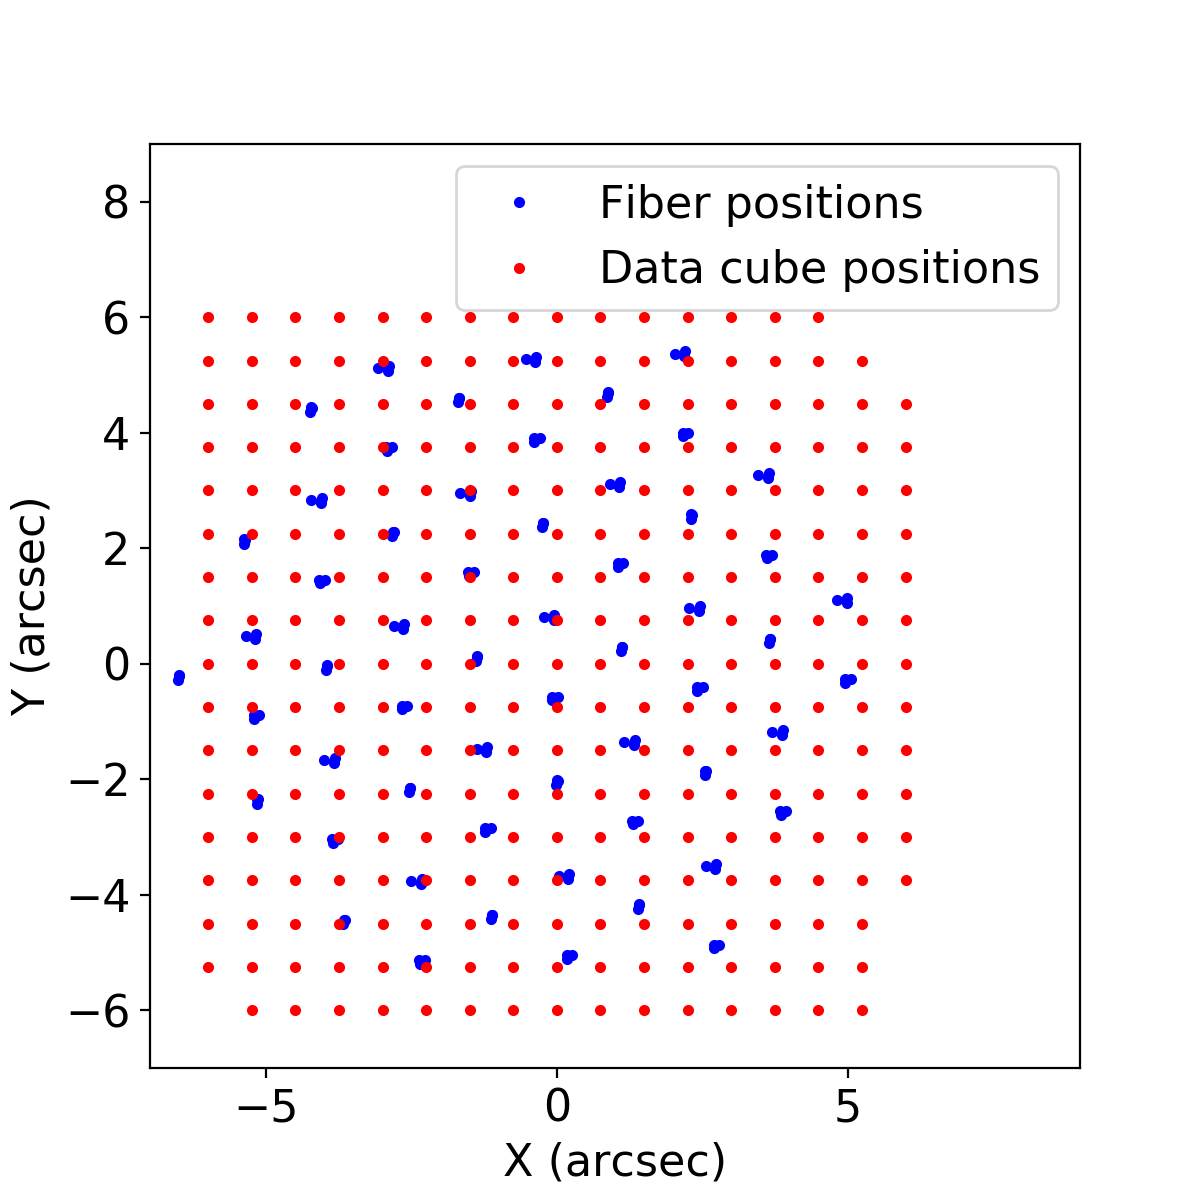

Text(0,0.5,'Y (arcsec)')

In [6]:
xsample = xpos[:, 1000]
ysample = ypos[:, 1000]
image = test_flux(xpos, ypos, 1000)
plt.figure(figsize=(6, 6))
font = {'family' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
plt.plot(xsample, ysample, '.', color='blue', label='Fiber positions')
plt.plot(image.ximage[image.ifit], image.yimage[image.ifit], '.',
         color='red', label='Data cube positions')
plt.legend(loc=1)
plt.xlim((-7., 9.))
plt.ylim((-7., 9.))
plt.xlabel('X (arcsec)')
plt.ylabel('Y (arcsec)')

<IPython.core.display.Javascript object>


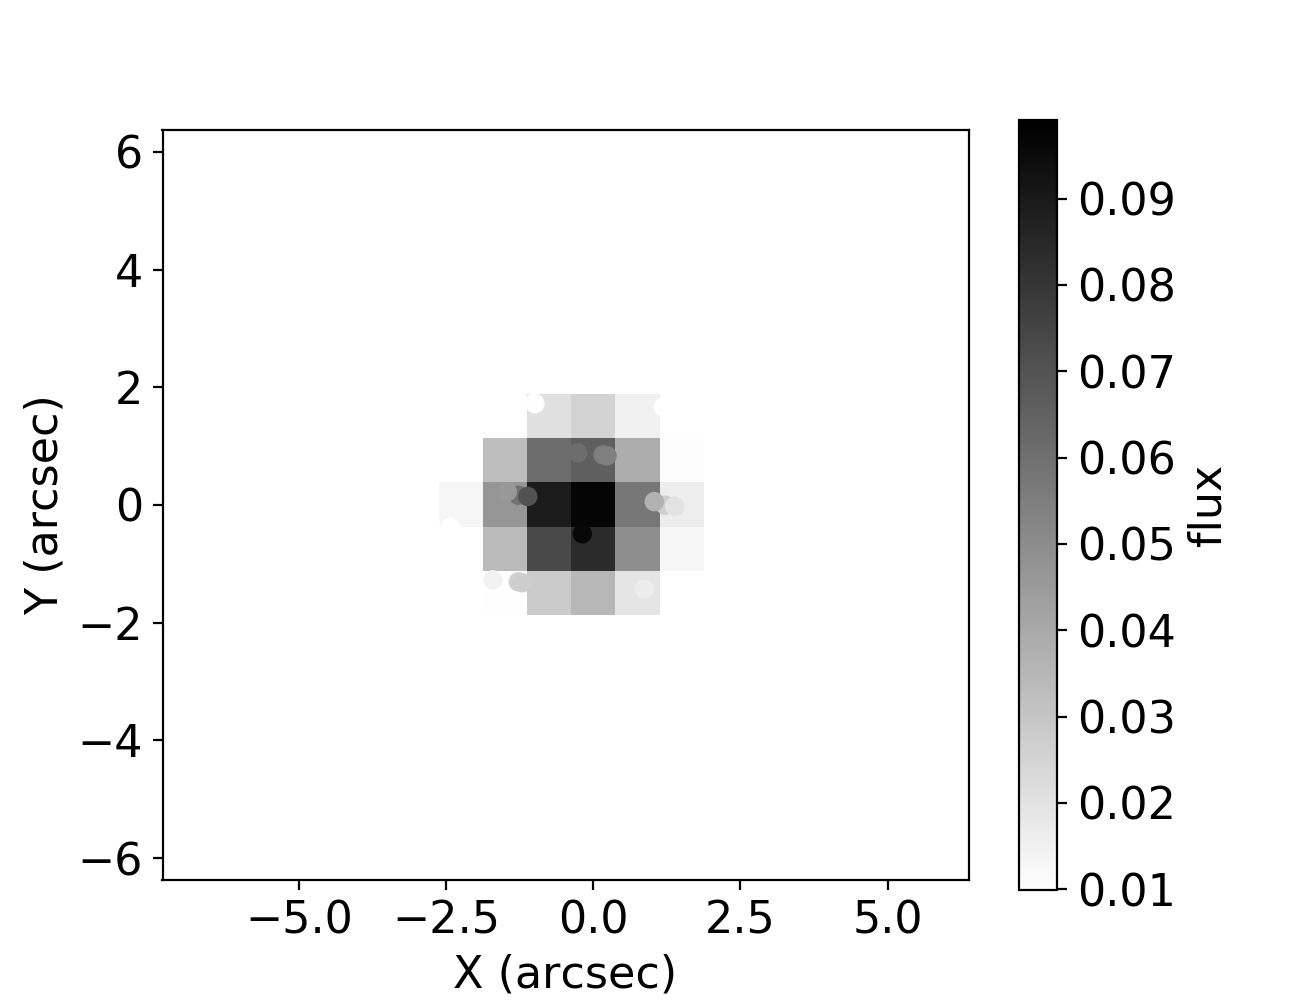

In [8]:
image = test_flux(xpos, ypos, 4000)
vmax = image.G_image.max() * 1.02
plt.figure(figsize=(6.5, 5.))
plt.imshow(image.G_image, extent=(image.xmin, image.xmax, image.ymin, image.ymax),
           cmap=cm.gray_r, vmin=0.1 * vmax, vmax=vmax)
plt.scatter(image.xsample, - image.ysample, c=image.fsample, vmin=0.1 * vmax, vmax=vmax, cmap=cm.gray_r)
plt.xlabel('X (arcsec)')
plt.ylabel('Y (arcsec)')
plt.colorbar(label='flux')

<IPython.core.display.Javascript object>


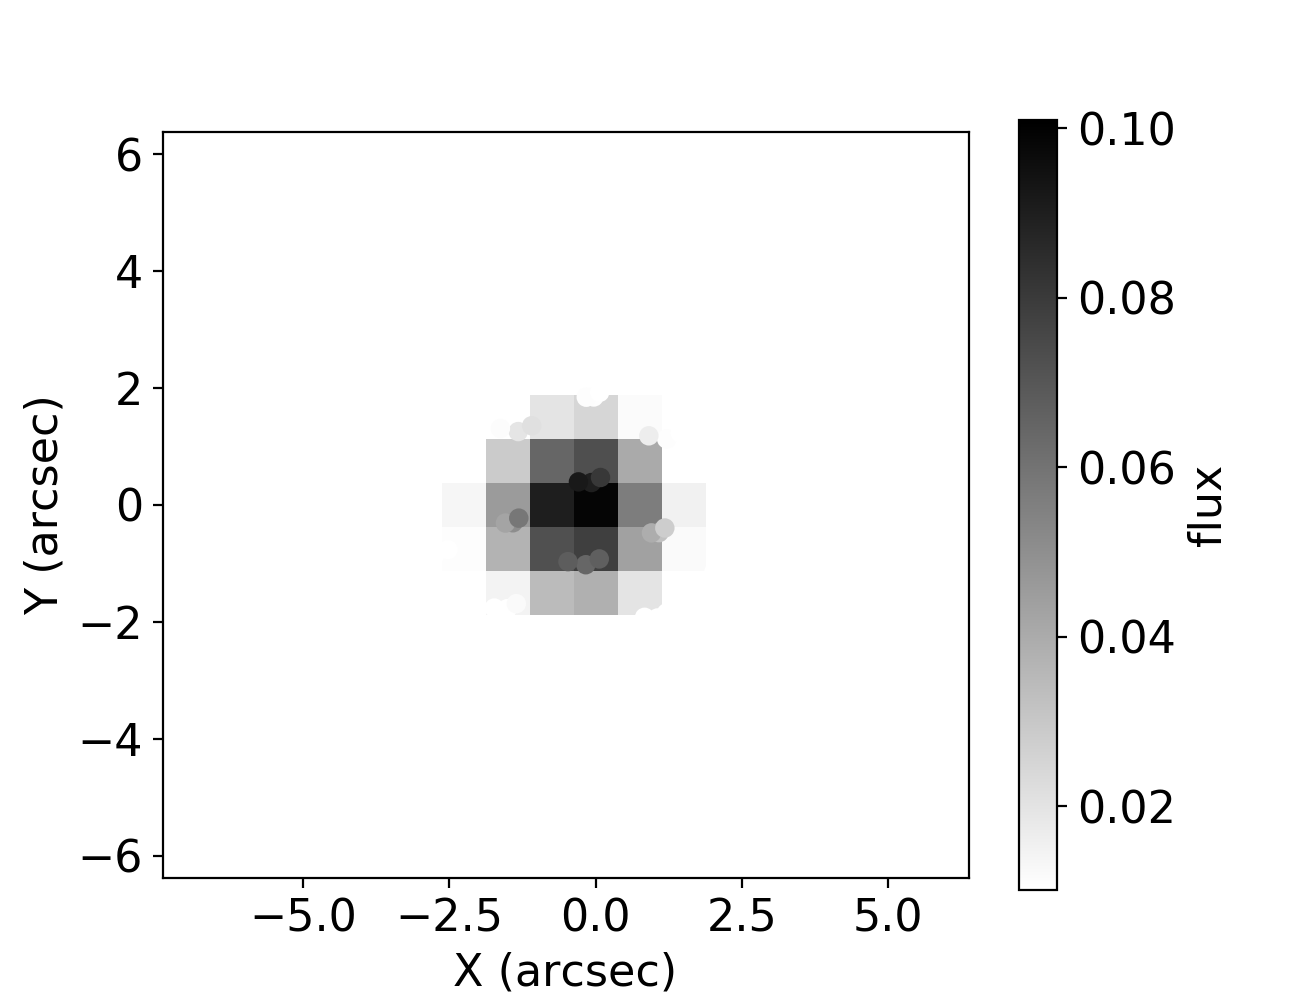

In [9]:
image = test_flux(xpos, ypos, 100)
vmax = image.G_image.max() * 1.02
plt.figure(figsize=(6.5, 5.))
plt.imshow(image.G_image, extent=(image.xmin, image.xmax, image.ymin, image.ymax),
           cmap=cm.gray_r, vmin=0.1 * vmax, vmax=vmax)
plt.scatter(image.xsample, - image.ysample, c=image.fsample, vmin=0.1 * vmax, vmax=vmax, cmap=cm.gray_r)
plt.xlabel('X (arcsec)')
plt.ylabel('Y (arcsec)')
plt.colorbar(label='flux')

In [10]:
for indx in np.arange(40):
    image = test_flux(xpos, ypos, indx * 100 + 10)
    print(image.G_image.sum())

1.0181853535268375
1.0204413115289466
1.022650791512266
1.0248106882545769
1.0269322604662188
1.0290126256593404
1.030985142320599
1.032851046279893
1.0345054474265398
1.0368035116008925
1.0377625866797424
1.0382046579437294
1.0381674708761228
1.0377235228233457
1.0370148405897013
1.0363487068686077
1.0351539772775735
1.0339432564816167
1.0327706791992974
1.0315299171780237
1.030298580110823
1.0290589823665377
1.0278068432990721
1.026575754065673
1.0254172449738588
1.024354174853909
1.0232977409366115
1.0223447768021243
1.021427009032664
1.020540553049474
1.01969164406463
1.0189127946025773
1.0181642773109771
1.0174385601787685
1.0167614377564929
1.0161812899815144
1.0156310091499208
1.0151532184262726
1.014684279767081
1.0142404343834548
